In [1]:
#Import tensorflow and keras library
import tensorflow as tf
import keras_preprocessing
from tensorflow.keras.preprocessing import image
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import keras
from tensorflow.keras.callbacks import ModelCheckpoint

print("[INFO]: Tensorflow version{}".format(tf.__version__))
state_gpu = tf.test.gpu_device_name()
print("[INFO]: GPU usage{0}".format(state_gpu))

Using TensorFlow backend.


[INFO]: Tensorflow version2.1.0
[INFO]: GPU usage/device:GPU:0


In [2]:
ROT_RANGE = 10

# this is the augmentation configuration we will use for training
train_gen = ImageDataGenerator(
rescale = 1./255,
rotation_range = ROT_RANGE,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale = 1./255)


In [3]:
TRAINING_DIR = '../input/tomato/New Plant Diseases Dataset(Augmented)/train/' 
VALIDATION_DIR = '../input/tomato/New Plant Diseases Dataset(Augmented)/valid/'

In [4]:
TARGET_SIZE = (224,224)
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 32
SEED = 42

#Data Iterator
train_data = train_gen.flow_from_directory(
TRAINING_DIR,
target_size = TARGET_SIZE,
class_mode = 'categorical',
color_mode = "rgb",
batch_size = TRAIN_BATCH_SIZE,
shuffle = True,
seed = SEED
)

valid_data = valid_gen.flow_from_directory(
VALIDATION_DIR,
target_size = TARGET_SIZE,
class_mode = 'categorical',
color_mode = "rgb",
batch_size = VALID_BATCH_SIZE
)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [5]:
from keras.applications.vgg16 import VGG16
base_model_weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=base_model_weights_path, include_top=False, input_shape=(224, 224, 3))

x = keras.layers.Flatten() (base_model.output)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x)
output = keras.layers.Dense(10, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# The newly added layers are initialized with random values.
# Make sure based model remain unchanged until newly added layers weights get reasonable values.
for layer in base_model.layers:
    layer.trainable = False

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
LEARNING_RATE = 0.0001
#LEARNING_RATE = 0.001

#Optimizer
opt = Adam(lr = LEARNING_RATE)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [8]:
TRAINING_NUM = train_data.n #or train_data.samples
VALID_NUM = valid_data.n
EPOCHS = 25

STEP_SIZE_TRAIN = TRAINING_NUM // TRAIN_BATCH_SIZE 
STEP_SIZE_VALID = VALID_NUM // VALID_BATCH_SIZE

# Fit model to get reasonable weights for newly added layers.
history = model.fit_generator(generator = train_data,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_data,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = EPOCHS)

Epoch 1/25
143/143 [==============================] - 319s 2s/step - loss: 1.3667 - accuracy: 0.5452 - val_loss: 0.7110 - val_accuracy: 0.7314
Epoch 2/25
143/143 [==============================] - 282s 2s/step - loss: 0.8520 - accuracy: 0.7262 - val_loss: 0.7263 - val_accuracy: 0.8247
Epoch 3/25
143/143 [==============================] - 281s 2s/step - loss: 0.7173 - accuracy: 0.7692 - val_loss: 0.5757 - val_accuracy: 0.8322
Epoch 4/25
143/143 [==============================] - 281s 2s/step - loss: 0.6330 - accuracy: 0.7971 - val_loss: 0.4696 - val_accuracy: 0.8335
Epoch 5/25
143/143 [==============================] - 280s 2s/step - loss: 0.5798 - accuracy: 0.8120 - val_loss: 0.4253 - val_accuracy: 0.8537
Epoch 6/25
143/143 [==============================] - 280s 2s/step - loss: 0.5414 - accuracy: 0.8241 - val_loss: 0.2611 - val_accuracy: 0.8667
Epoch 7/25
143/143 [==============================] - 279s 2s/step - loss: 0.5081 - accuracy: 0.8328 - val_loss: 0.5806 - val_accuracy: 0.8476

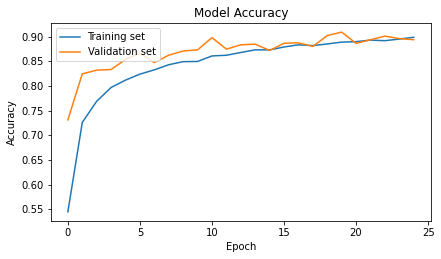

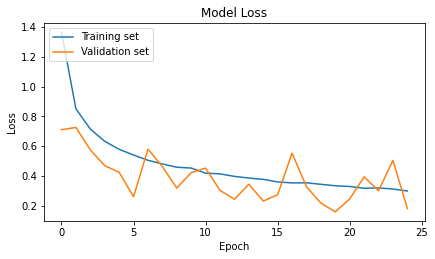

In [9]:
import matplotlib.pyplot as plt

plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [10]:
best_val_acc = max(history.history['val_accuracy'])
print("[INFO] Best Validation Accuracy: %",best_val_acc*100)

[INFO] Best Validation Accuracy: % 90.92905521392822


In [11]:
for layer in base_model.layers:
    layer.trainable = True

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate (This ensures the base model weights do not change a lot)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [12]:
TRAINING_NUM = train_data.n #or train_data.samples
VALID_NUM = valid_data.n
EPOCHS = 25

STEP_SIZE_TRAIN = TRAINING_NUM // TRAIN_BATCH_SIZE 
STEP_SIZE_VALID = VALID_NUM // VALID_BATCH_SIZE

# Fit model to get reasonable weights for newly added layers.
history = model.fit_generator(generator = train_data,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_data,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = EPOCHS)

Epoch 1/25
143/143 [==============================] - 321s 2s/step - loss: 0.2553 - accuracy: 0.9137 - val_loss: 0.2969 - val_accuracy: 0.9294
Epoch 2/25
143/143 [==============================] - 313s 2s/step - loss: 0.1931 - accuracy: 0.9330 - val_loss: 0.1213 - val_accuracy: 0.9284
Epoch 3/25
143/143 [==============================] - 312s 2s/step - loss: 0.1715 - accuracy: 0.9399 - val_loss: 0.0751 - val_accuracy: 0.9471
Epoch 4/25
143/143 [==============================] - 312s 2s/step - loss: 0.1472 - accuracy: 0.9489 - val_loss: 0.1280 - val_accuracy: 0.9433
Epoch 5/25
143/143 [==============================] - 320s 2s/step - loss: 0.1272 - accuracy: 0.9573 - val_loss: 0.3136 - val_accuracy: 0.9354
Epoch 6/25
143/143 [==============================] - 311s 2s/step - loss: 0.1164 - accuracy: 0.9601 - val_loss: 0.0438 - val_accuracy: 0.9572
Epoch 7/25
143/143 [==============================] - 313s 2s/step - loss: 0.1143 - accuracy: 0.9599 - val_loss: 0.0725 - val_accuracy: 0.9600

In [13]:
best_val_acc = max(history.history['val_accuracy'])
print("[INFO] Best Validation Accuracy: %",best_val_acc*100)

[INFO] Best Validation Accuracy: % 98.55040907859802


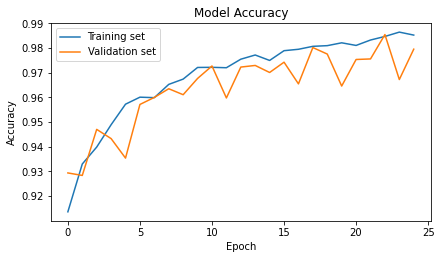

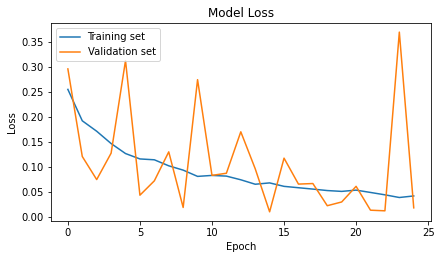

In [14]:
import matplotlib.pyplot as plt

plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()